In [27]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward
import lr_utils

In [28]:
np.random.seed(1)

In [29]:
def initialize_parameters(n_x, n_h, n_y):
    """
    此函数是为了初始化两层网络参数而使用的函数。
    参数：
        n_x - 输入层节点数量
        n_h - 隐藏层节点数量
        n_y - 输出层节点数量

    返回：
        parameters - 包含你的参数的python字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    assert W1.shape == (n_h, n_x)
    assert b1.shape == (n_h, 1)
    assert W2.shape == (n_y, n_h)
    assert b2.shape == (n_y, 1)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [30]:
def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表

    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l -1]) / np.sqrt(layers_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1])
        assert parameters['b' + str(l)].shape == (layers_dims[l], 1)

    return parameters

In [31]:
def linear_forward(A, W, b):
    """
    实现前向传播的线性部分。

    参数：
        A - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前图层的节点数量，前一图层的节点数量）
        b - 偏向量，numpy向量，维度为（当前图层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的字典，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W, A) + b
    assert Z.shape == (W.shape[0], A.shape[1])
    cache = (A, W, b)
    return Z, cache

In [32]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """
    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])
    cache = (linear_cache, activation_cache)

    return A, cache

In [44]:
def L_model_forward(X, parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION

    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出

    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2 # no. of layers
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])

    return AL, caches

In [34]:
def compute_cost(AL,Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m

    cost = np.squeeze(cost)
    assert cost.shape == ()

    return cost

In [35]:
def linear_backward(dZ, cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db

In [36]:
def linear_activation_backward(dA, cache, activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。

    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [37]:
def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播

    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache

    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [38]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数

    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出

    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2 #整除
    for l in range(L):
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [39]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x, n_h, n_y) = layers_dims

    """
    初始化参数
    """
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    """
    开始迭代
    """
    for i in range(num_iterations):
        # 前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')

        # 计算成本
        cost = compute_cost(A2, Y)

        # 后向传播
        ## 初始化反向传播
        dA2 = -(np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        ## 向后传播，输入“dA2，cache2，cache1”。 输出：“dA1，dW2，db2;还有dA0（未使用），dW1，db1”。
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        ##向后传播完成后的数据保存到grads
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']

        # 打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            # 记录成本
            costs.append(cost)
            # 是否打印成本值
            if print_cost:
                print("第", i, "次迭代，成本值为：", np.squeeze(cost))
    # 迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('costs')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()

    # 返回parameters
    return parameters

In [40]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

第 0 次迭代，成本值为： 0.6930497356599891
第 100 次迭代，成本值为： 0.6464320953428849
第 200 次迭代，成本值为： 0.6325140647912677
第 300 次迭代，成本值为： 0.6015024920354665
第 400 次迭代，成本值为： 0.5601966311605748
第 500 次迭代，成本值为： 0.515830477276473
第 600 次迭代，成本值为： 0.47549013139433266
第 700 次迭代，成本值为： 0.4339163151225749
第 800 次迭代，成本值为： 0.40079775362038855
第 900 次迭代，成本值为： 0.3580705011323797
第 1000 次迭代，成本值为： 0.33942815383664127
第 1100 次迭代，成本值为： 0.3052753636196264
第 1200 次迭代，成本值为： 0.2749137728213016
第 1300 次迭代，成本值为： 0.2468176821061484
第 1400 次迭代，成本值为： 0.19850735037466108
第 1500 次迭代，成本值为： 0.17448318112556646
第 1600 次迭代，成本值为： 0.17080762978095992
第 1700 次迭代，成本值为： 0.1130652456216474
第 1800 次迭代，成本值为： 0.09629426845937158
第 1900 次迭代，成本值为： 0.0834261795972687
第 2000 次迭代，成本值为： 0.07439078704319084
第 2100 次迭代，成本值为： 0.06630748132267934
第 2200 次迭代，成本值为： 0.05919329501038174
第 2300 次迭代，成本值为： 0.05336140348560556
第 2400 次迭代，成本值为： 0.048554785628770185


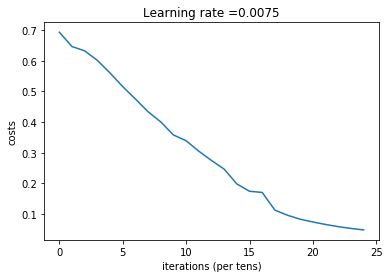

In [41]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

parameters = two_layer_model(train_x, train_y, layers_dims=layers_dims, num_iterations=2500, print_cost=True, isPlot=True)

In [42]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层

    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数

    返回：
     p - 给定数据集X的预测
    """

    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1, m))

    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("准确度为: " + str(float(np.sum((p == y)) / m)))

    return p

In [45]:
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

准确度为: 1.0
准确度为: 0.72


In [47]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。

    参数：
	    X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱

    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0,num_iterations):
        AL , caches = L_model_forward(X,parameters)

        cost = compute_cost(AL,Y)

        grads = L_model_backward(AL,Y,caches)

        parameters = update_parameters(parameters,grads,learning_rate)

        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

In [49]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

第 0 次迭代，成本值为： 0.715731513413713
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622127
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927773
第 500 次迭代，成本值为： 0.6060056229265339
第 600 次迭代，成本值为： 0.5690041263975134
第 700 次迭代，成本值为： 0.519796535043806
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069037
第 1100 次迭代，成本值为： 0.3057237457304711
第 1200 次迭代，成本值为： 0.26810152847740837
第 1300 次迭代，成本值为： 0.23872474827672607
第 1400 次迭代，成本值为： 0.20632263257914712
第 1500 次迭代，成本值为： 0.17943886927493552
第 1600 次迭代，成本值为： 0.15798735818801324
第 1700 次迭代，成本值为： 0.14240413012274078
第 1800 次迭代，成本值为： 0.128651659978866
第 1900 次迭代，成本值为： 0.11244314998157877
第 2000 次迭代，成本值为： 0.08505631034970913
第 2100 次迭代，成本值为： 0.05758391198608711
第 2200 次迭代，成本值为： 0.04456753454695279
第 2300 次迭代，成本值为： 0.038082751665983655
第 2400 次迭代，成本值为： 0.034410749018407606


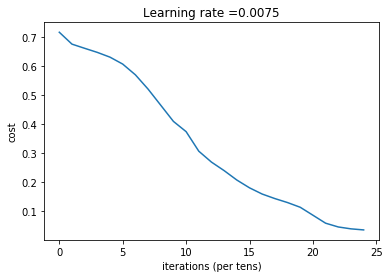

In [50]:
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True,isPlot=True)

In [51]:
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

准确度为: 0.9952153110047847
准确度为: 0.78
